# Gradient-based multislice ptychography with Jax

In [1]:
%matplotlib widget

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".15"

import asyncio
import abtem
import ase
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tqdm.auto as tqdm
from abtem.multislice import FresnelPropagator
from jax_multislice import transmission_function, FresnelPropagator as propagate, shift_kernel, energy2wavelength, get_frequencies

abtem.config.set({"device": "cpu"});


## Structure + Potential

First build a structure to simulate and reconstruct, for `MoS2` I stretch the unit cell in the z-direction to give more propagation between the slices.

In [2]:
atoms = ase.build.mx2(vacuum=0.8)
atoms.set_cell(atoms.cell * np.asarray([1, 1, 8]), scale_atoms=True)


In [3]:
atoms = abtem.orthogonalize_cell(atoms)
atoms *= (3, 2, 1)

Choose a slice thickness to acheive one slice-per-layer:

In [4]:
potential = abtem.Potential(
    atoms,
    sampling=0.2,
    slice_thickness=15,
)
print(potential.shape)

(3, 48, 56)


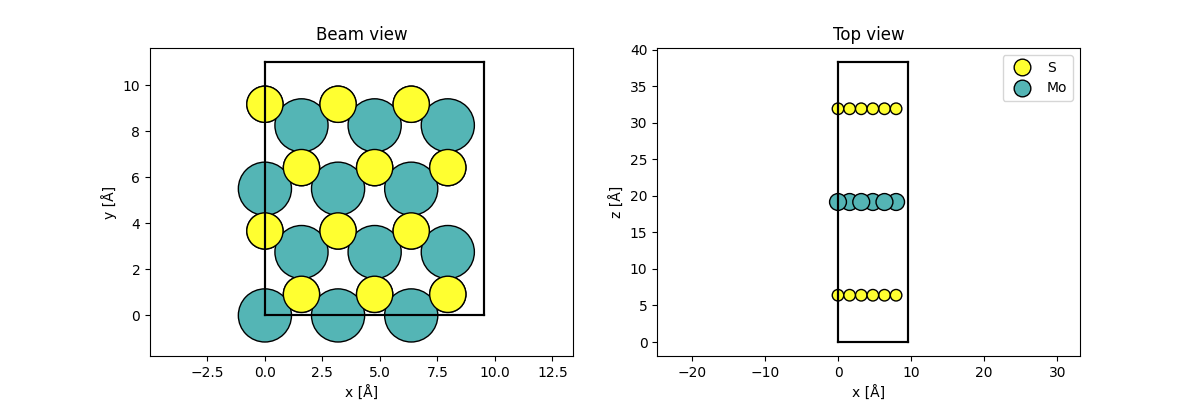

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Top view", legend=True);

We can also compute the complex transmission function for the potential

In [6]:
energy = 200e3

potential_array = potential.build(lazy=False).array
transmit = transmission_function(potential_array, energy)

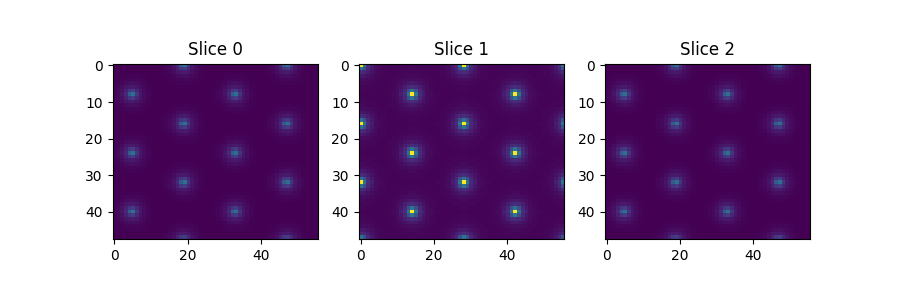

In [7]:
rows = int(np.floor(np.sqrt(len(potential_array))))
cols = int(np.ceil(np.sqrt(len(potential_array))))
if rows * cols < len(potential_array):
    cols += 1
fig, ax = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
vmin = potential_array.min()
vmax = potential_array.max()
for i, (p, s_ax) in enumerate(zip(potential_array, ax.ravel())):
    s_ax.imshow(p, vmin=vmin, vmax=vmax)
    s_ax.set_title(f"Slice {i}")

## Probe

Generate a probe with some aberrations:

In [8]:
wavelength = energy2wavelength(energy)
semiangle_cutoff = 40.
defocus = 40.
astigmatism = 0.
astigmatism_angle = 0.
Cs = 1e2
coma = 5e2
coma_angle = 0.
trefoil = 1e2
trefoil_angle = np.pi / 7

In [9]:
probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    defocus=defocus,
    Cs=Cs,
    astigmatism=astigmatism,
    astigmatism_angle=astigmatism_angle,
    trefoil=trefoil,
    trefoil_angle=trefoil_angle,
    coma=coma,
    coma_angle=coma_angle,
)
probe.grid.match(potential)
probe.shape

(48, 56)

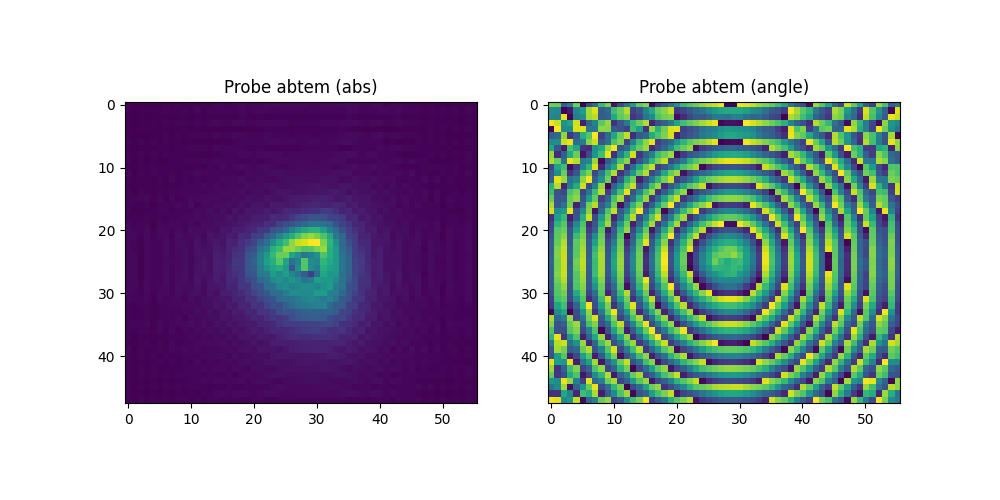

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(np.abs(probe.build(lazy=False).array))
ax1.set_title('Probe abtem (abs)');
ax2.imshow(np.angle(probe.build(lazy=False).array))
ax2.set_title('Probe abtem (angle)');

In [11]:
probe_waves = probe._build_waves(probe)

## Scan grid

In [12]:
grid_scan = abtem.GridScan(
    # start=(0.3, 0.3),
    # end=(0.7, 0.7),
    end=(1, 1),
    fractional=True,
    sampling=probe.aperture.nyquist_sampling * 2,
    potential=potential,
)
scan_positions = jnp.array(grid_scan.get_positions())
grid_scan.shape

(31, 36)

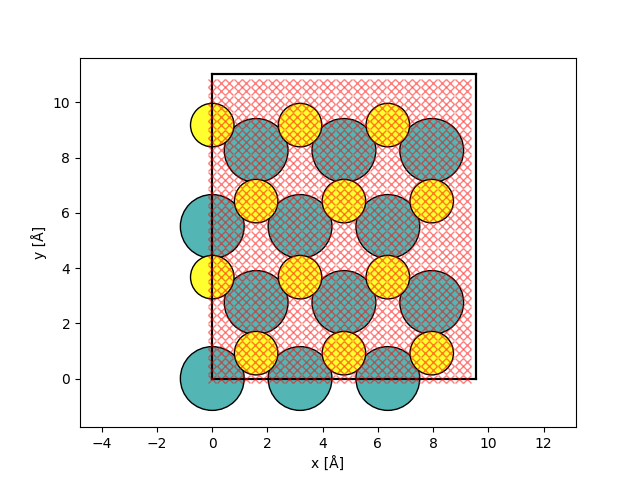

In [13]:
fig, ax = abtem.show_atoms(atoms)
scan_pos_flat = scan_positions.reshape(-1, 2)
ax.plot(scan_pos_flat[:, 0], scan_pos_flat[:, 1], 'rx', alpha=0.5);

We can also pre-generate all the probes for later use in iteration:

In [14]:
all_probes = probe.build(scan=grid_scan, lazy=False).array
all_probes_flat = jnp.array(all_probes.reshape(-1, *all_probes.shape[-2:]), dtype=jnp.complex64)

## Generate diffraction patterns

In [15]:
detector = abtem.PixelatedDetector(max_angle='full')
measurements = probe.scan(
    potential,
    scan=grid_scan,
    detectors=detector,
)
abtem_patterns = measurements.compute().array
abtem_patterns.shape

[########################################] | 100% Completed | 306.66 ms


(31, 36, 48, 56)

In [16]:
abtem_patterns_flat = abtem_patterns.reshape(-1, *abtem_patterns.shape[-2:])

## Check forward model

Build the forward model so as to return the exit wave and diffraction pattern:

In [17]:
def simulate_pattern(transmission, probe, prop_kernel):
    wavefront = probe
    
    for i in range(transmission.shape[0]):
        wavefront = wavefront * transmission[i]
        wavefront = propagate(wavefront, prop_kernel)
    
    exit_wave = wavefront
    
    diffraction_pattern = jnp.fft.fftshift(
        jnp.fft.fft2(wavefront)
    )
    diffraction_pattern = (
        jnp.square(diffraction_pattern.real)
        + jnp.square(diffraction_pattern.imag)
    )
    
    return exit_wave, diffraction_pattern

Forward model inputs:

In [18]:
slice_thickness = jnp.array(potential.slice_thickness[0])
prop_abtem = FresnelPropagator().get_array(probe_waves, float(slice_thickness))

Check the forward model against abTEM at a given scan grid position

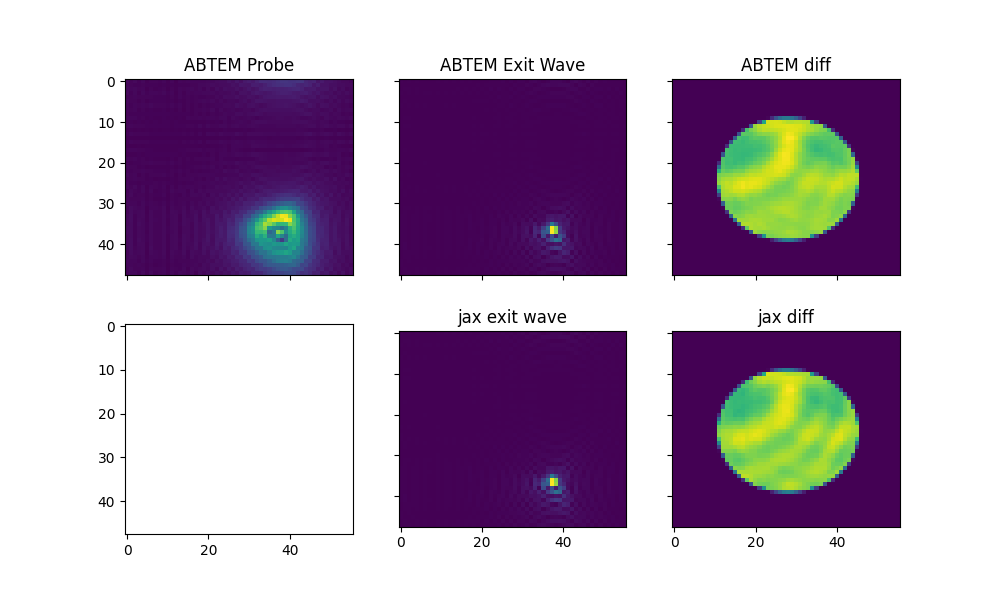

In [19]:
gx, gy = scan_positions.shape[:2]
idx_x, idx_y = 3 * gx // 4, 2 * gy  // 3
plot_scan = abtem.CustomScan(scan_positions[idx_x, idx_y])

plot_exit_wave = probe.scan(
    potential,
    scan=plot_scan,
    detectors=abtem.WavesDetector()
).compute(progress_bar=False).array.squeeze()
plot_probe = probe.build(scan=plot_scan).compute(progress_bar=False).array.squeeze()

jax_exit_wave, jax_pattern = simulate_pattern(
    transmit,
    all_probes[idx_x, idx_y],
    prop_abtem,
)

fig, ax = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)
ax = ax.T.ravel()
ax[0].imshow(np.abs(plot_probe))
ax[0].set_title('ABTEM Probe')
# ax[1].imshow(np.abs(jax_probe_shifted))
# ax[1].set_title('jax probe')
ax[2].imshow(np.abs(plot_exit_wave))
ax[2].set_title('ABTEM Exit Wave')
ax[3].imshow(np.abs(jax_exit_wave))
ax[3].set_title('jax exit wave')
ax[4].imshow(np.abs(abtem_patterns[idx_x, idx_y]))
ax[4].set_title('ABTEM diff')
ax[5].imshow(np.abs(jax_pattern))
ax[5].set_title('jax diff');

There are still some residual differences between abTEM and Jax diffraction patterns, to be explored:

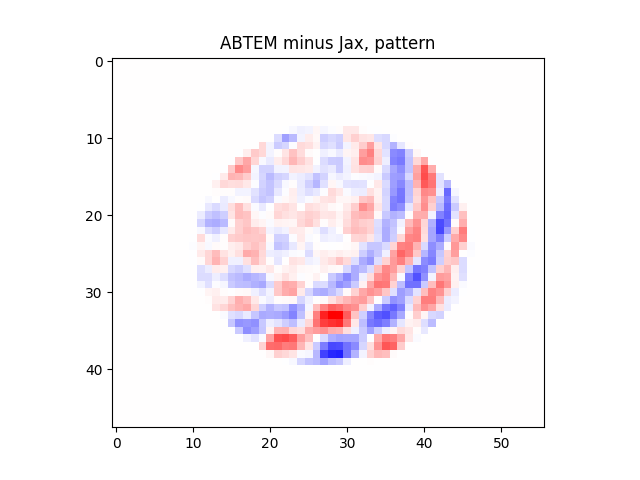

In [20]:
fig, ax = plt.subplots()
difference = abtem_patterns[idx_x, idx_y] - jax_pattern
vmax = np.abs(difference).max()
ax.imshow(difference, vmin=-vmax, vmax=vmax, cmap="bwr")
ax.set_title('ABTEM minus Jax, pattern');

## Inverse multislice, object only

JIT the forward model:

In [21]:
simulate_pattern_jit = jax.vmap(jax.jit(simulate_pattern), in_axes=(None, 0, None))

Loss function for the fitting against the abTEM diffraction pattern. Use the L2 loss of the pattern, plus a term forcing the object to have unit amplitude:

In [22]:
def loss(abtem_patterns, transmit, probes, prop_kernel):
    _, jax_patterns = simulate_pattern_jit(transmit, probes, prop_kernel)  # don't need the exit wave
    return (
        jnp.mean(
            optax.l2_loss(jax_patterns, abtem_patterns)
        )
    )

loss_jit = jax.jit(loss)

Pick the number of reconstruction slices and generate the inputs to the forward model:

In [23]:
num_slices_recon = 3
recon_obj_shape = (num_slices_recon, *transmit.shape[-2:])
recon_slice_thickness = float(sum(potential.slice_thickness) / num_slices_recon)

# Use the abTEM propagator, needs to match the slice thickness in the reconstruction
prop_abtem = FresnelPropagator().get_array(probe_waves, recon_slice_thickness)

We can choose to optimise against abTEM's diffration patterns or patterns generated with the forward model:

In [24]:
_, jax_patterns_flat = simulate_pattern_jit(transmit, all_probes_flat, prop_abtem)
# target_patterns = abtem_patterns_flat
target_patterns = jax_patterns_flat
target_name = 'jax'

Create the blank transmission object we are going to optimise:

In [25]:
opt_transmit = jnp.ones(recon_obj_shape, dtype=jnp.complex64)

Initialize the optimiser. Contrary to typical use of ADAM this problem can accept a very high initial learning rate.

In [ ]:
learning_rate = 1e1
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(opt_transmit)

Create a plot which will be updated during iteration with the loss value.

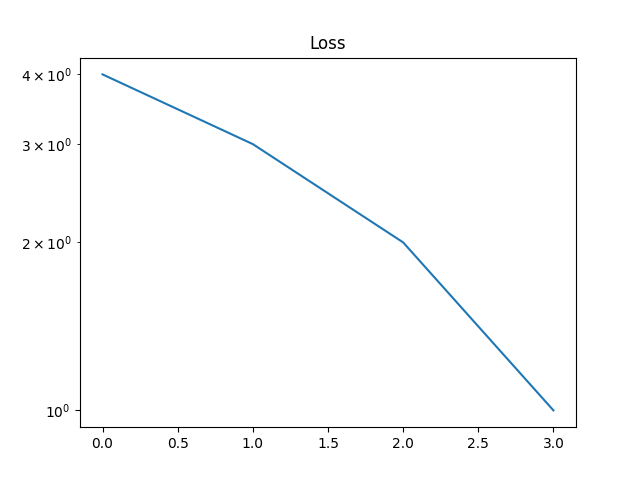

In [27]:
fig, ax = plt.subplots()
loss_plot = ax.plot(np.arange(1, 5)[::-1])[0]
ax.set_title("Loss");
ax.set_yscale("log")

In [28]:
# This is necessary to let the above plot initialize
await asyncio.sleep(0.5)

Run reconstruction over randomised batches of diffraction patterns (`chunksize` at a time), for a total of `num_epochs` passes over the data.

In [29]:
num_epochs = 1_000  # number of passes through the dataset
chunksize = 256  # number of patterns used to compute an update step

num_patterns = len(target_patterns)
iteration_idxs = np.arange(num_patterns)
chunks = tuple(
    slice(ix, min(ix + chunksize, num_patterns))
    for ix in range(0, num_patterns, chunksize)
)
chunks = chunks[:-1]  # skip the last chunk as it may be incomplete, which will add a periodic spike in the loss, not an issue as we are shuffling
assert len(chunks) > 0, "Chunksize is too large for this dataset"

num_iterations = len(chunks) * num_epochs
ax.set_xlim(0, num_iterations)
loss_plot.set_xdata(np.arange(num_iterations))
losses = np.full((num_iterations,), np.nan)

val_grad_fn = jax.value_and_grad(loss_jit, argnums=1)

iteration = 0
for epoch in (outer_pbar := tqdm.trange(num_epochs)):
    np.random.shuffle(iteration_idxs)
    for chunk in chunks:
        loss_val, grads = val_grad_fn(
            target_patterns[iteration_idxs[chunk]],
            opt_transmit,
            all_probes_flat[iteration_idxs[chunk]],
            prop_abtem,
        )
        # Conjugating the gradients is necessary in Jax, we are not sure why
        grads = jnp.conjugate(grads)
        updates, opt_state = optimizer.update(grads, opt_state)
        opt_transmit = optax.apply_updates(opt_transmit, updates)
        losses[iteration] = loss_val
        iteration += 1
    if (epoch % 10) == 0:
        outer_pbar.set_description(f"Loss {losses[max(0, iteration - 20):iteration].mean(): .3e}")
        loss_plot.set_ydata(losses)
        ax.set_ylim(0.1 * losses[:iteration].min(), 1.1 * losses[:iteration].max())
        fig.canvas.draw()

  0%|          | 0/1000 [00:00<?, ?it/s]

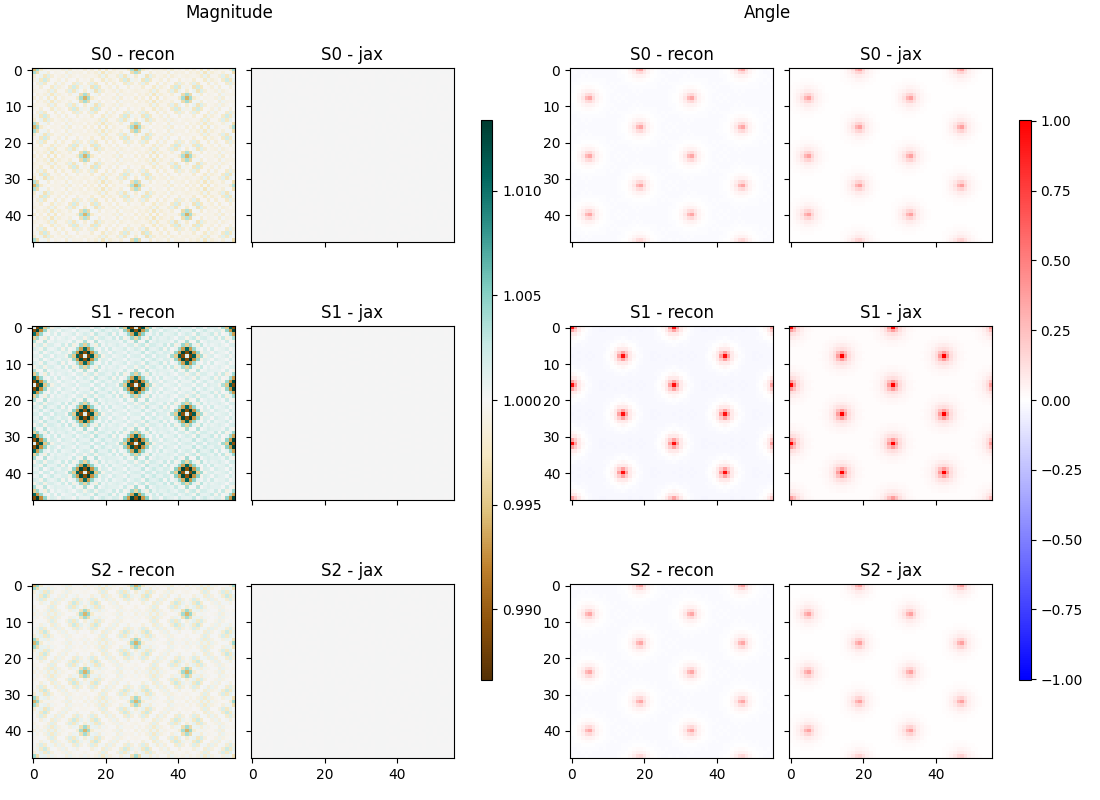

In [30]:
fig = plt.figure(layout="constrained", figsize=(11, 8))
subfigs = fig.subfigures(1, 3, wspace=0.22, width_ratios=[1, 1, 0.05])

axs = subfigs[0].subplots(num_slices_recon, 2, sharex=True, sharey=True)
a_max = max(np.abs((np.abs(opt_transmit) - 1)).max(), np.abs((np.abs(transmit) - 1)).max())
ang_max = max(np.abs(np.angle(opt_transmit)).max(), np.abs(np.angle(transmit)).max())


for i, (recon_slice, abtem_slice, (ax1, ax2)) in enumerate(zip(opt_transmit, transmit, axs)):
    im_abs = ax1.imshow(np.abs(recon_slice), vmin=1 - a_max, vmax=1 + a_max, cmap="BrBG")
    ax1.set_title(f"S{i} - recon")
    ax2.imshow(np.abs(abtem_slice), vmin=1 - a_max, vmax=1 + a_max, cmap="BrBG")
    ax2.set_title(f"S{i} - {target_name}")
subfigs[0].suptitle("Magnitude")
cbar_ax = subfigs[0].add_axes([1.05, 0.15, 0.025, 0.7])
subfigs[0].colorbar(im_abs, cax=cbar_ax)

num_slices_potential = transmit.shape[0]
axs = subfigs[1].subplots(num_slices_potential, 2, sharex=True, sharey=True)
for i, (recon_slice, abtem_slice, (ax1, ax2)) in enumerate(zip(opt_transmit, transmit, axs)):
    im_ang = ax1.imshow(np.angle(recon_slice), cmap="bwr", vmin=-ang_max, vmax=ang_max)
    ax1.set_title(f"S{i} - recon")
    ax2.imshow(np.angle(abtem_slice), cmap="bwr", vmin=-ang_max, vmax=ang_max)
    ax2.set_title(f"S{i} - {target_name}")
subfigs[1].suptitle("Angle");
cbar_ax = subfigs[1].add_axes([1.05, 0.15, 0.025, 0.7])
subfigs[1].colorbar(im_ang, cax=cbar_ax);

## Inverse multislice, just probe reconstruction

As we are optimising the probe, we need a new forward model which can shift a single probe array to the scan coordinates:

In [55]:
def simulate_pattern_shifting(transmit, probe_fft, scan_position, prop_kernel, shift_frequencies):
    probe = jnp.fft.ifft2(
        probe_fft * shift_kernel(*scan_position, *shift_frequencies)
    )
    wavefront = probe
    
    for i in range(transmit.shape[0]):
        wavefront = wavefront * transmit[i]
        wavefront = propagate(wavefront, prop_kernel)
    
    diffraction_pattern = jnp.fft.fftshift(
        jnp.fft.fft2(wavefront)
    )
    diffraction_pattern = (
        jnp.square(diffraction_pattern.real)
        + jnp.square(diffraction_pattern.imag)
    )
    return diffraction_pattern, probe

simulate_pattern_shifting_jit = jax.vmap(
    jax.jit(
        simulate_pattern_shifting
    ),
    in_axes=(None, None, 0, None, None),
)

In [56]:
def loss_with_probe(abtem_patterns, transmit, probe_fft, scan_positions, prop_kernel, shift_frequencies):
    jax_patterns, _ = simulate_pattern_shifting_jit(
        transmit,
        probe_fft,
        scan_positions,
        prop_kernel,
        shift_frequencies,
    )
    return (
        jnp.mean(
            optax.l2_loss(jax_patterns, abtem_patterns)
        )
    )

loss_with_probe_jit = jax.jit(loss_with_probe)

Initial probe:

In [57]:
initial_probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    defocus=defocus,
)
initial_probe.grid.match(potential)
initial_probe_array = initial_probe.build((0., 0.), lazy=False).array

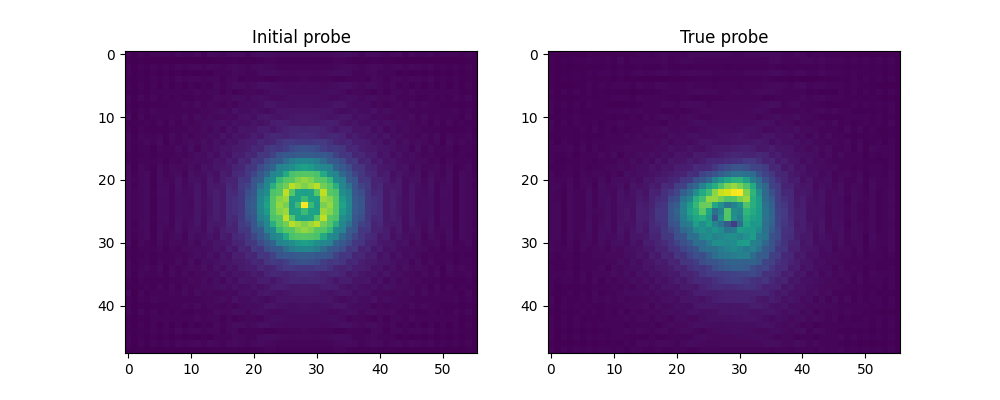

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(np.abs(np.fft.fftshift(initial_probe_array)))
ax1.set_title("Initial probe")
ax2.imshow(np.abs(np.fft.fftshift(all_probes_flat[0])))
ax2.set_title("True probe");

To shift the probe we also need the arrays of frequencies in FFT space:

In [59]:
shift_frequencies = get_frequencies(transmit.shape[-2:], potential.sampling)

Probe optimizer

In [60]:
opt_probe_fft = jnp.fft.fft2(initial_probe_array)
probe_learning_rate = 1e-1
optimizer_probe = optax.adam(probe_learning_rate)
opt_state_probe = optimizer_probe.init(opt_probe_fft)

In [61]:
chunksize = 256
chunks = tuple(
    slice(ix, min(ix + chunksize, num_patterns))
    for ix in range(0, num_patterns, chunksize)
)

val_and_grad_probe = jax.value_and_grad(loss_with_probe_jit, argnums=2)

for epoch in (outer_pbar := tqdm.trange(1000)):
    np.random.shuffle(iteration_idxs)
    for chunk in chunks:
        loss_val, grads_probe = val_and_grad_probe(
            target_patterns[iteration_idxs[chunk]],
            transmit,
            opt_probe_fft,
            scan_pos_flat[iteration_idxs[chunk]],
            prop_abtem,
            shift_frequencies,
        )
        grads_probe = jnp.conjugate(grads_probe)
        updates_probe, opt_state_probe = optimizer_probe.update(grads_probe, opt_state_probe)
        opt_probe_fft = optax.apply_updates(opt_probe_fft, updates_probe)
        outer_pbar.set_description(f"Loss {loss_val: .3e}")

  0%|          | 0/1000 [00:00<?, ?it/s]

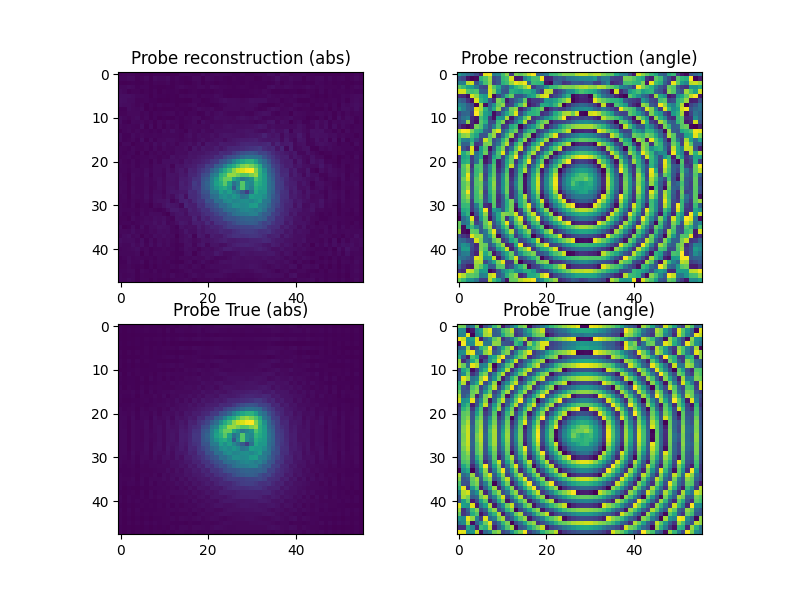

In [68]:
probe_recon = jnp.fft.ifftshift(jnp.fft.ifft2(opt_probe_fft))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
ax1.imshow(np.abs(probe_recon))
ax1.set_title('Probe reconstruction (abs)');
ax2.imshow(np.angle(probe_recon))
ax2.set_title('Probe reconstruction (angle)');
ax3.imshow(np.abs(np.fft.fftshift(all_probes_flat[0])))
ax3.set_title('Probe True (abs)');
ax4.imshow(np.angle(np.fft.fftshift(all_probes_flat[0])))
ax4.set_title('Probe True (angle)');

## Inverse multislice, object + probe

We can use the same loss function to optimise both probe and object

In [76]:
initial_probe_array = initial_probe.build((0., 0.), lazy=False).array
opt_probe_fft = jnp.fft.fft2(initial_probe_array)
probe_learning_rate = 1e-1
optimizer_probe = optax.adam(probe_learning_rate)
opt_state_probe = optimizer_probe.init(opt_probe_fft)

In [77]:
opt_transmit = jnp.ones(recon_obj_shape, dtype=jnp.complex64)
object_learning_rate = 1e0
optimizer_object = optax.adam(object_learning_rate)
opt_state_object = optimizer_object.init(opt_transmit)

In [78]:
chunksize = 256
chunks = tuple(
    slice(ix, min(ix + chunksize, num_patterns))
    for ix in range(0, num_patterns, chunksize)
)

val_and_grad_objprobe = jax.value_and_grad(loss_with_probe_jit, argnums=(1, 2))

for epoch in (outer_pbar := tqdm.trange(3000)):
    np.random.shuffle(iteration_idxs)
    for batch_idx, chunk in enumerate(chunks):
        loss_val, (grads_object, grads_probe) = val_and_grad_objprobe(
            target_patterns[iteration_idxs[chunk]],
            opt_transmit,
            opt_probe_fft,
            scan_pos_flat[iteration_idxs[chunk]],
            prop_abtem,
            shift_frequencies,
        )
        if epoch > 50 and (epoch // 10 % 3) == 0:
            grads_probe = jnp.conjugate(grads_probe)
            updates_probe, opt_state_probe = optimizer_probe.update(grads_probe, opt_state_probe)
            opt_probe_fft = optax.apply_updates(opt_probe_fft, updates_probe)
            optimising = "Probe"
        else:
            grads_object = jnp.conjugate(grads_object)
            updates_object, opt_state_object = optimizer_object.update(grads_object, opt_state_object)
            opt_transmit = optax.apply_updates(opt_transmit, updates_object)
            optimising = "Object"
        outer_pbar.set_description(f"Loss {loss_val: .3e}, opt: {optimising}")

  0%|          | 0/3000 [00:00<?, ?it/s]

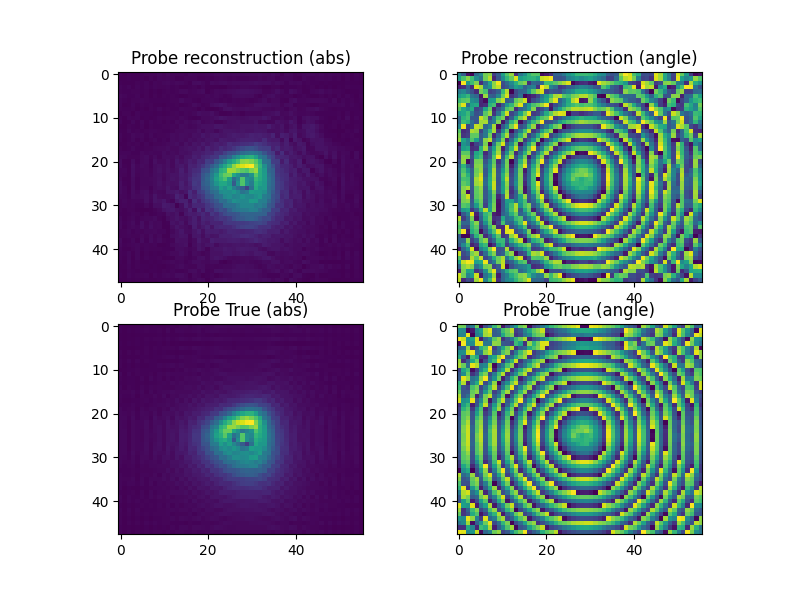

In [79]:
probe_recon = jnp.fft.ifftshift(jnp.fft.ifft2(opt_probe_fft))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
ax1.imshow(np.abs(probe_recon))
ax1.set_title('Probe reconstruction (abs)');
ax2.imshow(np.angle(probe_recon))
ax2.set_title('Probe reconstruction (angle)');
ax3.imshow(np.abs(np.fft.fftshift(all_probes_flat[0])))
ax3.set_title('Probe True (abs)');
ax4.imshow(np.angle(np.fft.fftshift(all_probes_flat[0])))
ax4.set_title('Probe True (angle)');

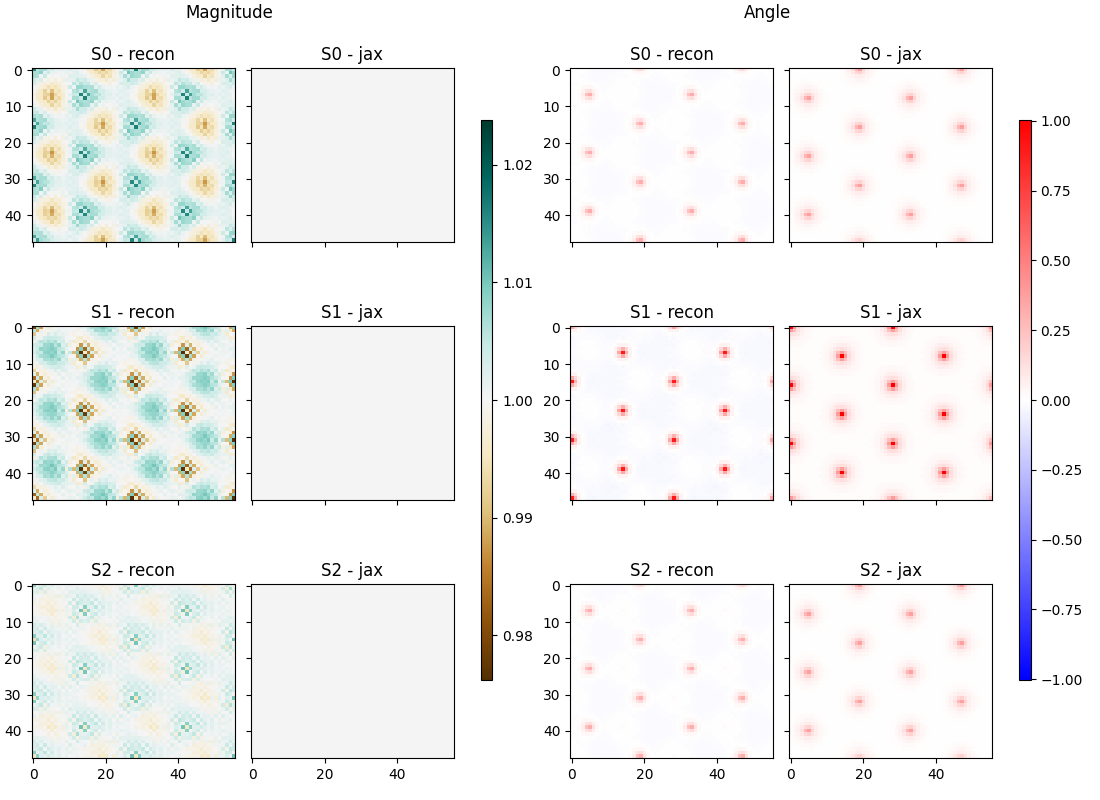

In [80]:
fig = plt.figure(layout="constrained", figsize=(11, 8))
subfigs = fig.subfigures(1, 3, wspace=0.22, width_ratios=[1, 1, 0.05])

axs = subfigs[0].subplots(num_slices_recon, 2, sharex=True, sharey=True)
a_max = max(np.abs((np.abs(opt_transmit) - 1)).max(), np.abs((np.abs(transmit) - 1)).max())
ang_max = max(np.abs(np.angle(opt_transmit)).max(), np.abs(np.angle(transmit)).max())


for i, (recon_slice, abtem_slice, (ax1, ax2)) in enumerate(zip(opt_transmit, transmit, axs)):
    im_abs = ax1.imshow(np.abs(recon_slice), vmin=1 - a_max, vmax=1 + a_max, cmap="BrBG")
    ax1.set_title(f"S{i} - recon")
    ax2.imshow(np.abs(abtem_slice), vmin=1 - a_max, vmax=1 + a_max, cmap="BrBG")
    ax2.set_title(f"S{i} - {target_name}")
subfigs[0].suptitle("Magnitude")
cbar_ax = subfigs[0].add_axes([1.05, 0.15, 0.025, 0.7])
subfigs[0].colorbar(im_abs, cax=cbar_ax)

num_slices_potential = transmit.shape[0]
axs = subfigs[1].subplots(num_slices_potential, 2, sharex=True, sharey=True)
for i, (recon_slice, abtem_slice, (ax1, ax2)) in enumerate(zip(opt_transmit, transmit, axs)):
    im_ang = ax1.imshow(np.angle(recon_slice), cmap="bwr", vmin=-ang_max, vmax=ang_max)
    ax1.set_title(f"S{i} - recon")
    ax2.imshow(np.angle(abtem_slice), cmap="bwr", vmin=-ang_max, vmax=ang_max)
    ax2.set_title(f"S{i} - {target_name}")
subfigs[1].suptitle("Angle");
cbar_ax = subfigs[1].add_axes([1.05, 0.15, 0.025, 0.7])
subfigs[1].colorbar(im_ang, cax=cbar_ax);